# COVID-19 Brasil - Multi-Layer Perceptron (MLP)

## Conteúdo

O seguinte *notebook* é o resultado da estimação do comportamento dos dados da COVID-19 no Brasil, numa Rede Neural Artifical Multi-Layer Perceptron(MLP). 

In [1]:
import sys

!conda install --yes --prefix {sys.prefix} pandas
!conda install --yes --prefix {sys.prefix} numpy
!conda install --yes --prefix {sys.prefix} nbformat
!conda install --yes --prefix {sys.prefix} plotly==4.6.0
!conda install --yes --prefix {sys.prefix} psutil requests
!conda install --yes --prefix {sys.prefix} scikit-learn
!conda install --yes --prefix {sys.prefix} plotly-orca==1.2.1
!conda install --yes --prefix {sys.prefix} matplotlib
!conda install --yes --prefix {sys.prefix} statsmodels

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.



In [2]:
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
from plotly.graph_objs import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')


pio.renderers.default = "svg"

Primeiro, é necessário preparar os dados para o modelo. Definiu-se que o holdout seria realizar o treino com 90% dos dados (90% desde primeiro dia) e o teste com os 10% dias restantes.

In [3]:
data = pd.read_csv('./data/brazil_covid19.csv')

df1 = data.groupby(['date'])['cases','deaths'].agg('sum')
df1 = df1.reset_index()
df1['days'] = range(1,len(df1) + 1,1)

# Treino
days_train = df1['days'][:int(0.9*len(df1))]
cases_train = df1['cases'][:int(0.9*len(df1))]

# Teste
days_test = df1['days'][int(0.9*len(df1)):]
cases_test =  df1['cases'][int(0.9*len(df1)):]

estimate = len(df1) - len(days_test)

print("Total Dados: %d, Treino: %d dias, Teste: %d dia" % (len(df1),len(days_train),len(days_test)))

Total Dados: 111, Treino: 99 dias, Teste: 12 dia


Com os dados preparados, de seguida iremos treinar a rede neural.

Depois de testar vários parâmetros para treinar a rede, optamos por usar 400 (200,200) neurónios e a função de activação **relu**, com vista a atingir um modelo razoável.

In [4]:
# Treino da rede neural
mlp = MLPRegressor(hidden_layer_sizes=(200,200),activation='relu',solver='lbfgs',max_iter=1000, shuffle=True)
mlp.fit(X=days_train.values.reshape(-1,1),y=cases_train.values.ravel())
cases_estimate = mlp.predict(days_test.values.reshape(-1,1))

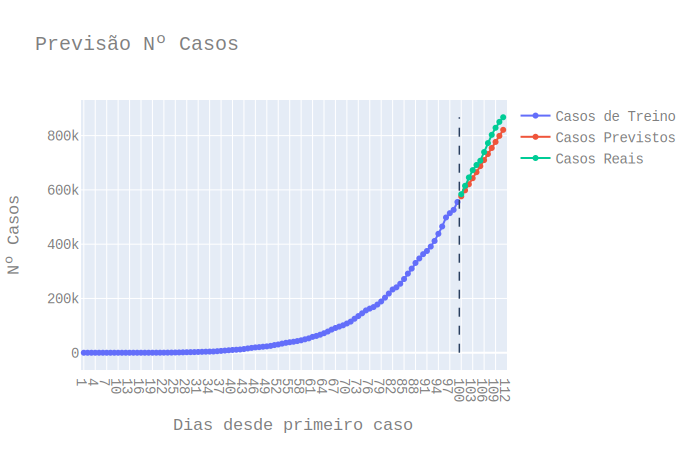

In [5]:
# Plot
layout = Layout(
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    ),
    title= "Previsão Nº Casos",
    xaxis_title="Dias desde primeiro caso",
    yaxis_title="Nº Casos",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 3,
        range=[0,len(df1)+1]
    )
)

fig = go.Figure(data=[
    go.Scatter(x=days_train, y=cases_train, name='Casos de Treino',mode="lines+markers"),
    go.Scatter(x=days_test, y=cases_estimate, name = 'Casos Previstos',mode="lines+markers"),
    go.Scatter(x=days_test, y=cases_test, name = 'Casos Reais',mode="lines+markers")
])

fig.add_shape(
        dict(
            type="line",
            x0=estimate + 0.5,
            y0=120,
            x1=estimate + 0.5,
            y1=max(df1['cases']),
            line=dict(
                width=1.5,
                dash= "dash"
            )
))

fig['layout'].update(layout)
fig.show()

In [6]:
print("Erro Médio Absoluto: {0:6.3f} casos".format(mean_absolute_error(cases_test,cases_estimate)))
print("R2-Score: {0:6.4f}".format(r2_score(cases_test,cases_estimate)))

Erro Médio Absoluto: 32833.974 casos
R2-Score: 0.8424


Ao analisar o gráfico, repara-se que o modelo tem bons resultados quanto ao nº de casos de teste em comparação ao nº real.
No entanto, para melhorar os resultados, decidimos atacar o problema usando um auto-correlação da série temporal.

In [7]:
df2 = df1.copy()
df2.head()
df2.set_index('days',inplace=True)
df2.drop(['date','deaths'],axis=1,inplace=True)

No gráfico seguinte podemos observar que há uma correlação significativa no lag 1, que decresce depois de alguns lags. Este padrão indica um termo auto-regressivo. Isto significa que usando o dia anterior e o dia actual, é melhor para prever o dia seguinte.

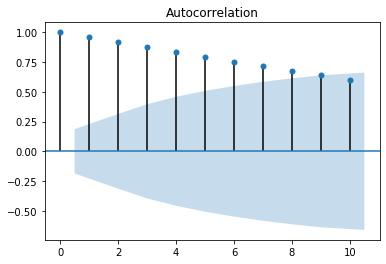

In [8]:
sm.graphics.tsa.plot_acf(df2.values.squeeze(), lags=10)
plt.show()

In [9]:
df2['yesterday'] = df2['cases'].shift(1,fill_value=0)
df2.reset_index(level=0, inplace=True)
df2.head()

# Treino
days_train = df2[['days','yesterday']][:int(0.9*len(df2))]
cases_train = df2['cases'][:int(0.9*len(df2))]

# Teste
days_test = df2[['days','yesterday']][int(0.9*len(df2)):]
cases_test =  df2['cases'][int(0.9*len(df2)):]

estimate = len(df2) - len(days_test)

print("Total Dados: %d, Treino: %d dias, Teste: %d dia" % (len(df1),len(days_train),len(days_test)))

Total Dados: 111, Treino: 99 dias, Teste: 12 dia


In [10]:
# Treino da rede neural
mlp = MLPRegressor(hidden_layer_sizes=(200,200),activation='relu',solver='lbfgs',max_iter=1000, shuffle=True)
mlp.fit(X=days_train.values,y=cases_train.values.ravel())
cases_estimate = mlp.predict(days_test.values)

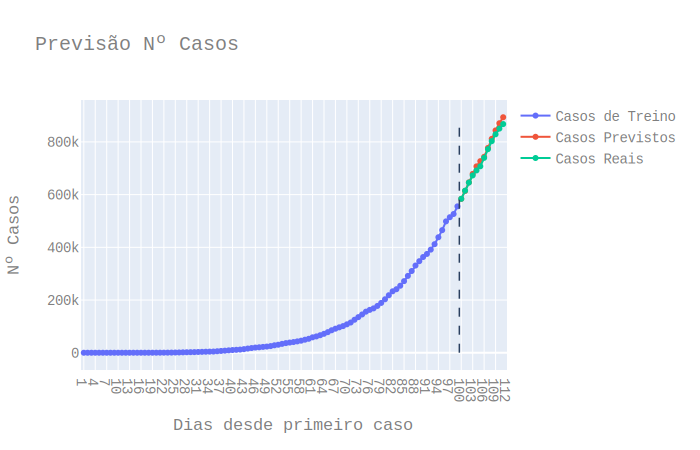

In [11]:
# Plot
layout = Layout(
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    ),
    title= "Previsão Nº Casos",
    xaxis_title="Dias desde primeiro caso",
    yaxis_title="Nº Casos",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 3,
        range=[0,len(df2)+1]
    )
)

fig = go.Figure(data=[
    go.Scatter(x=days_train['days'], y=cases_train, name='Casos de Treino',mode="lines+markers"),
    go.Scatter(x=days_test['days'], y=cases_estimate, name = 'Casos Previstos',mode="lines+markers"),
    go.Scatter(x=days_test['days'], y=cases_test, name = 'Casos Reais',mode="lines+markers")
])

fig.add_shape(
        dict(
            type="line",
            x0=estimate + 0.5,
            y0=120,
            x1=estimate + 0.5,
            y1=max(df2['cases']),
            line=dict(
                width=1.5,
                dash= "dash"
            )
))

fig['layout'].update(layout)
fig.show()

In [12]:
print("Erro Médio Absoluto: {0:6.3f} casos".format(mean_absolute_error(cases_test,cases_estimate)))
print("R2-Score: {0:6.4f}".format(r2_score(cases_test,cases_estimate)))

Erro Médio Absoluto: 10038.538 casos
R2-Score: 0.9788


Com a mudança realizada, conseguimos melhorar ainda mais o modelo anterior.
Podemos concluir que este modelo é bastante apropriado no que diz respeito à previsão da série temporal.